In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 04/07/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [16]:
file = project_path + 'data_cut_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [17]:
#file4 = '/project/lgrandi/ccapelli/haxcache/bkg_newmaps_pax6.10.1_aftercuts.haxcache'
#data4 = hax.minitrees.load_cache_file(file4)

#data = [data1, data4]
#data = pd.concat(data, ignore_index=True)
#del data1, data4

In [18]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


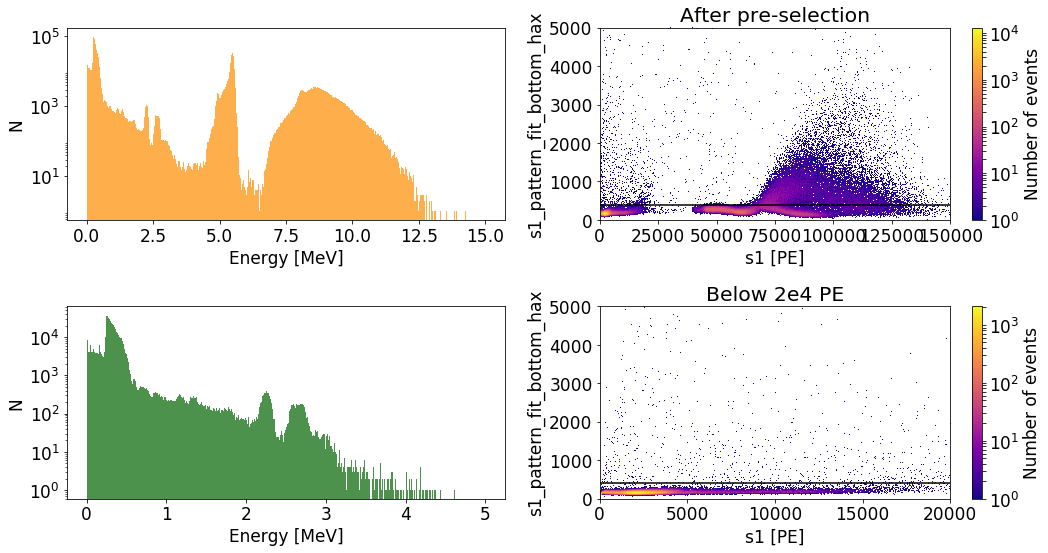

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,1.5e5), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=1.5e5, xmin=0, colors='k', linestyles='solid')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=2e4, xmin=0, colors='k', linestyles='solid')


plt.tight_layout()
plt.show()

### Cut definition 

In [8]:
def S1PatternLikelihoodProfile_old(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

def S1PatternLikelihoodProfile_old_2(x, a, b, c, d):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5)

In [9]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def poly1(x, p0, p1):
    return p0 + p1 * x

def poly2(x, p0, p1, p2):
    return p0 + p1 * x + p2 * x**2

def poly3(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3

def poly1_3(x, p0, p1, p3):
    return p0 + p1 * x + p3 * x**3

def exp(x, p0, p1, p3):
    return p0 + p1 *np.exp(-p3*x)

def S1PatternLikelihoodProfile_new(x, p0, p1, p2, p3, p4, p5):
    return poly5(x, p0, p1, p2, p3, p4, p5)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

# On z

In [23]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,800), 
                                         range=((-83.45, -13.45), (0.0,1000))
                                         )

ybins_center_z = np.asarray([0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)])
xbins_center_z = np.asarray([0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)])

#perc_1 = np.empty(len(xbins_center_1))
#for i in tqdm(range(len(hist_1))):
perc_z = percentile_numeric(hist = hist_1, xbins= xbins_1, ybins = ybins_1, q=0.98)
    #perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.997, var1='s1', var2='s1 patter fit hax')
    
#xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
#xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit
del hist_1, xbins_1, ybins_1

100%|██████████| 100/100 [00:00<00:00, 1935.86it/s]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


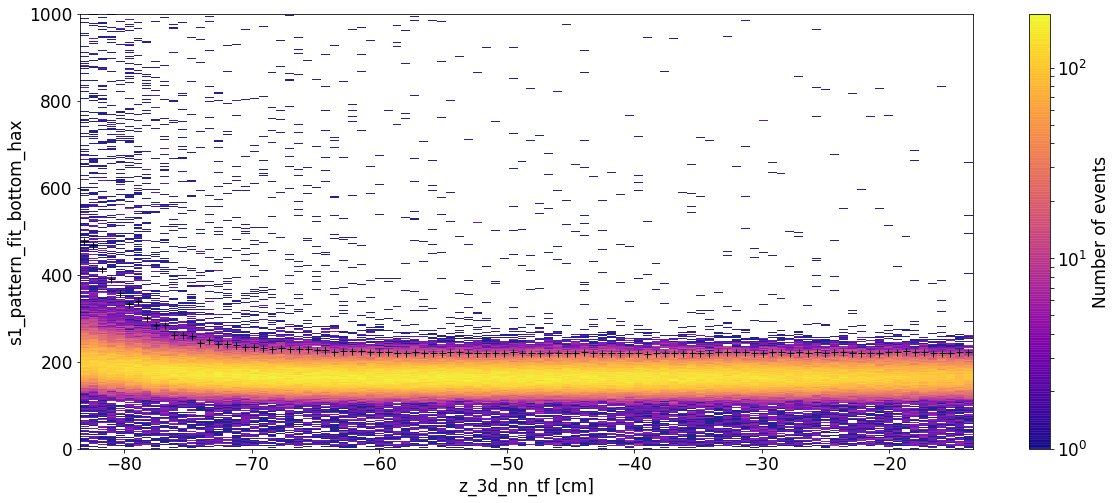

In [24]:
fig = plt.figure(figsize=(20,8))

hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.9)
plt.plot(xbins_center_z, perc_z, 'k+', ms = 7)
plt.colorbar(label='Number of events')

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

del hist_z, xbins_z, ybins_z, _

## Fit of the cut

popt_z:  [  2.21038928e+02   5.98806454e-07   2.39846789e-01] 

pcov_z:  [[  1.83321315e-01  -3.00335217e-08   6.01160087e-04]
 [ -3.00335217e-08   3.47660029e-14  -7.10726628e-10]
 [  6.01160087e-04  -7.10726628e-10   1.45387070e-05]]


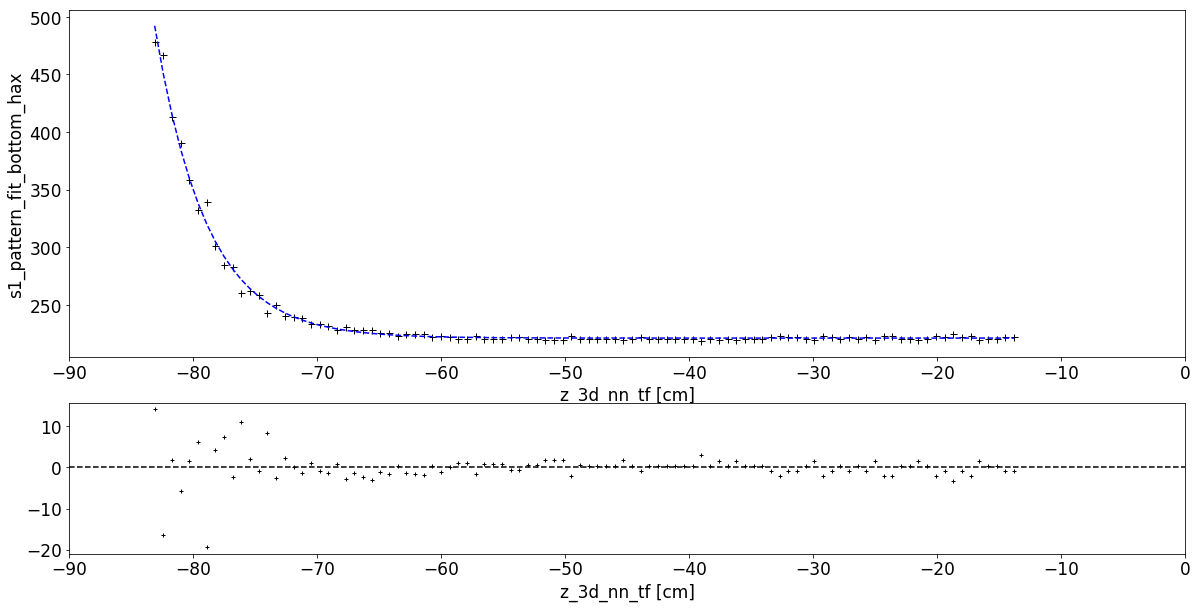

In [25]:
init_z = [2.085e+02,   2.47289420e-07,   2.40508404e-01]

popt_z, pcov_z = curve_fit(exp, xbins_center_z, perc_z, p0=init_z)
print('popt_z: ', popt_z ,'\n\npcov_z: ', pcov_z)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_z, perc_z, 'k+', ms = 7)
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z), 'b--')
plt.xlim(-90,0)

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z) - perc_z, 'k+', ms=4)
plt.hlines(y=0, xmin=-90, xmax = 0 , linestyles='dashed')
plt.xlim(-90,0)
plt.xlabel('z_3d_nn_tf [cm]')

### Cut

In [26]:
data_cut_z = data.copy()
data_cut_z['CutS1PF_z'] = (data_cut_z['s1_pattern_fit_bottom_hax'] < exp(data_cut_z['z_3d_nn_tf'], *popt_z))
data_cut_z = hax.cuts.selection(data_cut_z, data_cut_z['CutS1PF_z'] == True)

Unnamed selection: 20139 rows removed (97.72% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


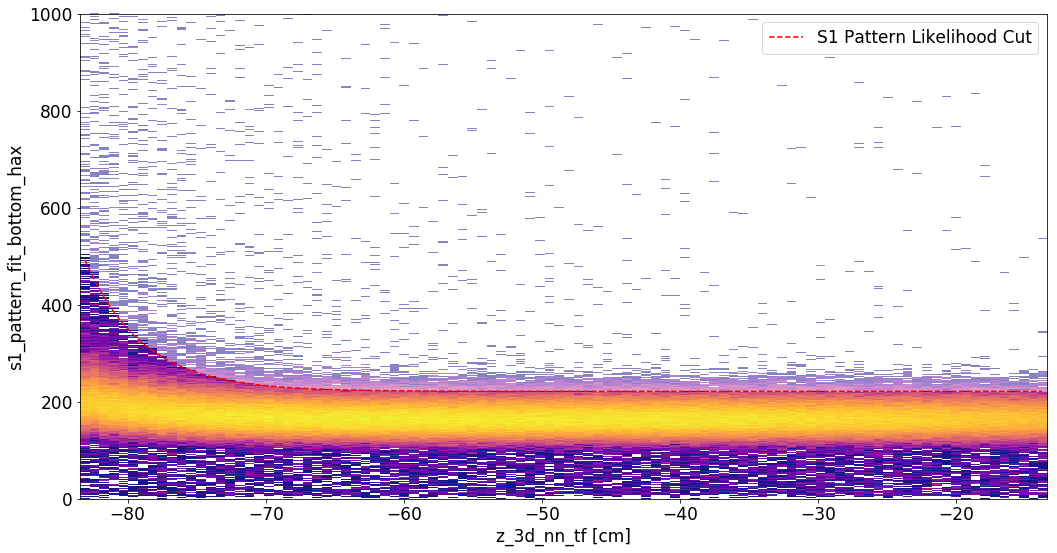

In [27]:
y = []
for i in range(len(xbins_center_z)):
    y.append(exp(xbins_center_z[i], *popt_z))

plt.figure(figsize=(15,8))
hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.5)
hist_z_cut, xbins_z_cut, ybins_z_cut, _ = plt.hist2d(data_cut_z['z_3d_nn_tf'], 
                                         data_cut_z['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.9)
plt.plot(xbins_center, y, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist_z[np.isnan(hist_z)] = 0
hist_z_cut[np.isnan(hist_z_cut)] = 0

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


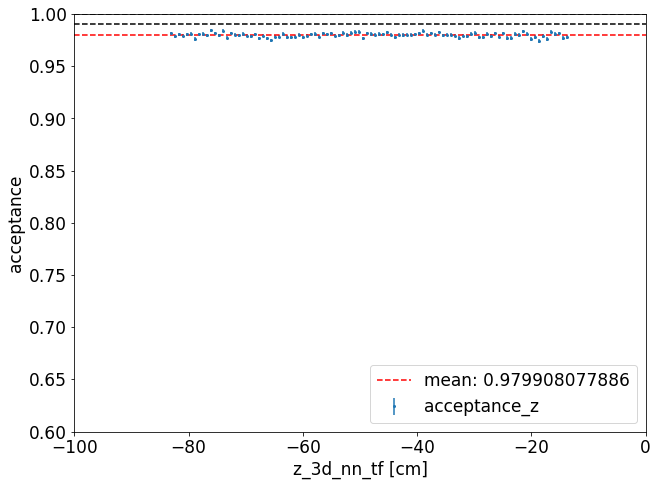

In [28]:
bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_z_cut[i].sum()/hist_z[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_z[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

plt.figure(figsize=(10.24, 7.68))

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.60, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

del bin_centers_acceptance_z, acceptance_z, sigma_z
del hist_z, xbins_z, ybins_z
del hist_z_cut, xbins_z_cut, ybins_z_cut
del Acceptance_z, tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


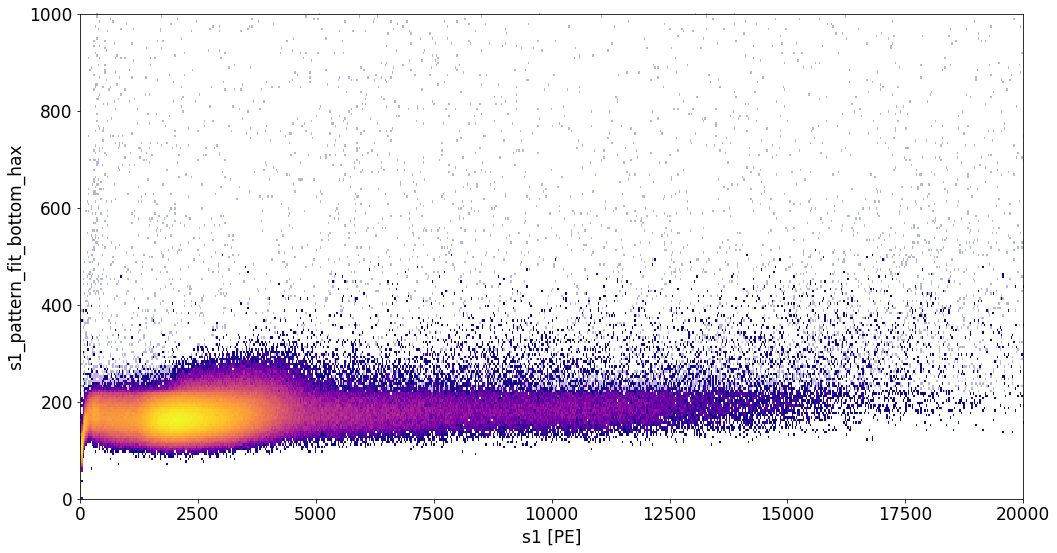

In [29]:
plt.figure(figsize=(15,8))
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
plt.hist2d(data_cut_z['s1'], data_cut_z['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
#plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()

## On S1

In [31]:
data = data_cut_z.copy()

100%|██████████| 10/10 [00:00<00:00, 11.80it/s]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


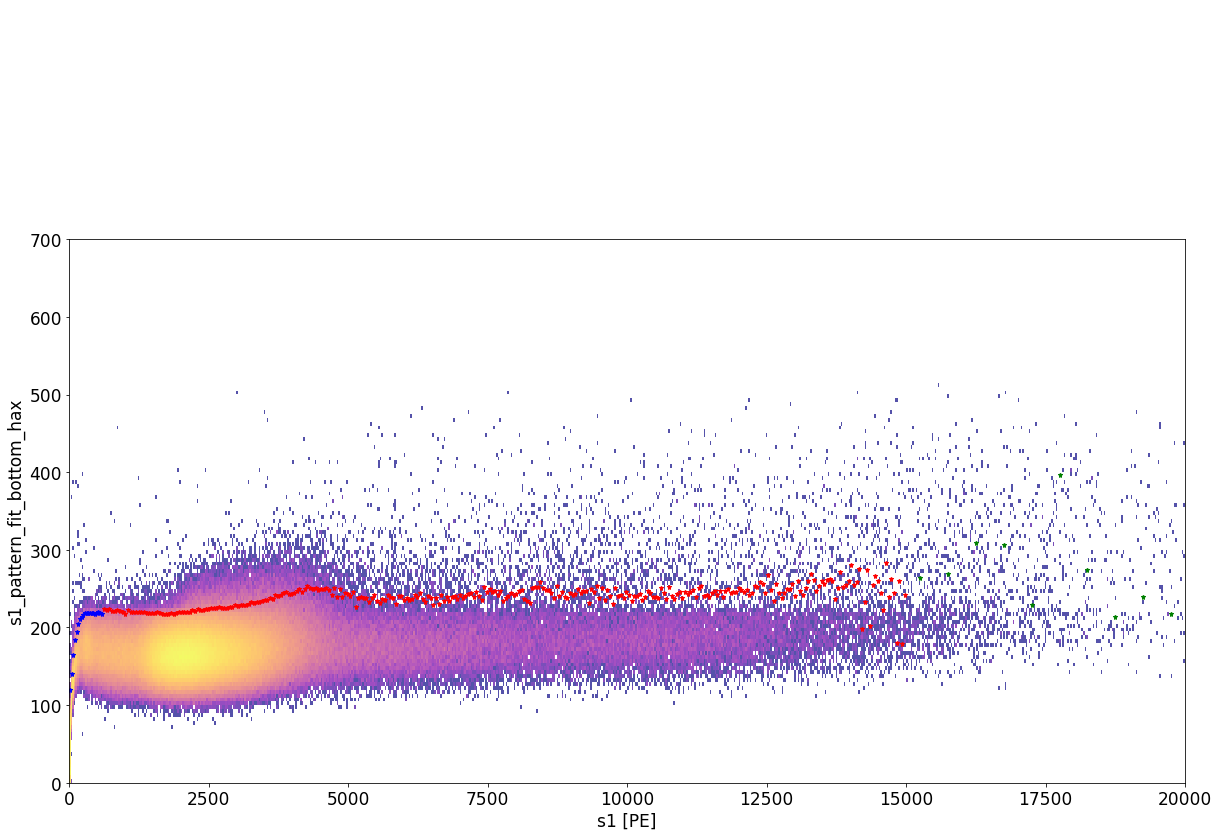

In [32]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (20, 200), 
                                   range=((0,600), (0,1000))
                                   )
ybins_center_1 = [0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)]
xbins_center_1 = [0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)]

perc_1 = np.empty(len(xbins_center_1))
for i in tqdm(range(len(hist_1))):
    perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

hist_2, xbins_2, ybins_2 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (300, 200), 
                                   range=((600,1.5e4), (0,1000))
                                   )
ybins_center_2 = [0.5*(ybins_2[i]+ybins_2[i+1]) for i in range(len(ybins_2)-1)]
xbins_center_2 = [0.5*(xbins_2[i]+xbins_2[i+1]) for i in range(len(xbins_2)-1)]

perc_2 = np.empty(len(xbins_center_2))
for i in tqdm(range(len(hist_2))):
    perc_2[i] = percentile(index = i, hist=hist_2, ybins=ybins_2, xbins=xbins_2, q=0.99, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_2, perc_valid_2 = dropNaNforFit(xbins_center_2, perc_2)
xbins_center_valid_2, perc_valid_2 = dropNegforFit(xbins_center_valid_2, perc_valid_2)

hist_3, xbins_3, ybins_3 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (10, 200), 
                                   range=((1.5e4,2e4), (0,1000))
                                   )
ybins_center_3 = [0.5*(ybins_3[i]+ybins_3[i+1]) for i in range(len(ybins_3)-1)]
xbins_center_3 = [0.5*(xbins_3[i]+xbins_3[i+1]) for i in range(len(xbins_3)-1)]

perc_3 = np.empty(len(xbins_center_3))
for i in tqdm(range(len(hist_3))):
    perc_3[i] = percentile(index = i, hist=hist_3, ybins=ybins_3, xbins=xbins_3, q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_3, perc_valid_3 = dropNaNforFit(xbins_center_3, perc_3)
xbins_center_valid_3, perc_valid_3 = dropNegforFit(xbins_center_valid_3, perc_valid_3)

hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
                                               range=((0,2e4), (0,1000)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 0.7)
plt.plot(xbins_center_valid_1, perc_valid_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_2, perc_valid_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_3, perc_valid_3, 'g*', lw=2, ms=5)

plt.xlim(0,2e4)
plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

xbins_center_valid = np.concatenate((xbins_center_valid_1, xbins_center_valid_2, xbins_center_valid_3))
perc_valid = np.concatenate((perc_valid_1, perc_valid_2, perc_valid_3))

plt.show()

# Fit of the cut

popt_1:  [  4.19090402e+01   2.12216644e+01  -8.26696223e-01   1.05856092e-02] 

pcov_1:  [[  4.95461870e+01  -9.29001391e+00   5.06155082e-01  -8.36695403e-03]
 [ -9.29001391e+00   1.91441670e+00  -1.09903108e-01   1.87785972e-03]
 [  5.06155082e-01  -1.09903108e-01   6.52954990e-03  -1.14286951e-04]
 [ -8.36695403e-03   1.87785972e-03  -1.14286951e-04   2.03728899e-06]]

popt_2:  [  2.11792647e+02   7.85251134e-03  -6.36533324e-07   1.93210755e-11] 

pcov_2:  [[  2.37710539e+01  -9.29203368e-03   9.92328991e-07  -3.11925397e-11]
 [ -9.29203368e-03   4.16389092e-06  -4.76532149e-10   1.56566445e-14]
 [  9.92328991e-07  -4.76532149e-10   5.73408626e-14  -1.95839010e-18]
 [ -3.11925397e-11   1.56566445e-14  -1.95839010e-18   6.92131202e-23]]


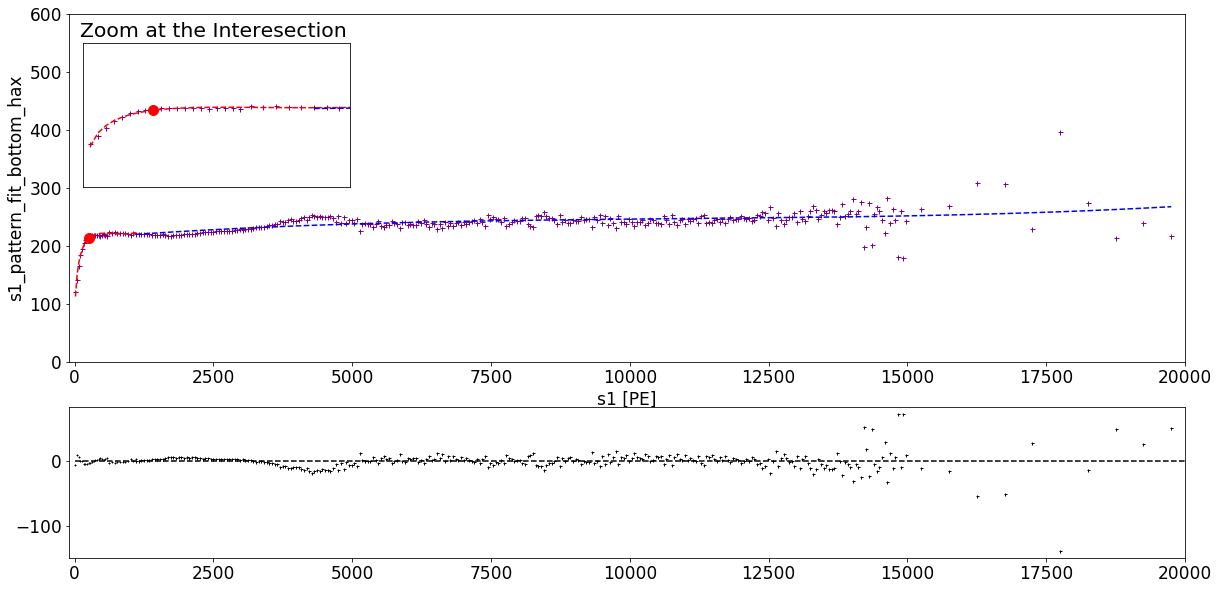

In [33]:
init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1, pcov_1 = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid[:30], perc_valid[:30], p0=init_1)
print('popt_1: ', popt_1 ,'\n\npcov_1: ', pcov_1)

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]

popt_2, pcov_2 = curve_fit(poly3, xbins_center_valid[30:], perc_valid[30:], p0=init_2)
print('\npopt_2: ',popt_2, '\n\npcov_2: ', pcov_2)

idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid, *popt_1) - \
                                  poly3(xbins_center_valid, *popt_2)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1), 'r--')
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,600)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.axes([0.135, 0.64, .185, .2], facecolor='w')
plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:35], *popt_1), 'r--')
plt.plot(xbins_center_valid[25:], poly3(xbins_center_valid[25:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-10, 10e2)
plt.ylim(0,400)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1)-perc_valid[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2)-perc_valid[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)

plt.show()

In [34]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile_old_2(data_cut['s1'], *popt_1))*(data_cut['s1']<xbins_center_valid[idx][0]))
                      +((data_cut['s1_pattern_fit_bottom_hax'] < poly3(data_cut['s1'], *popt_2))*(data_cut['s1']>=xbins_center_valid[idx][0])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 15403 rows removed (98.22% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


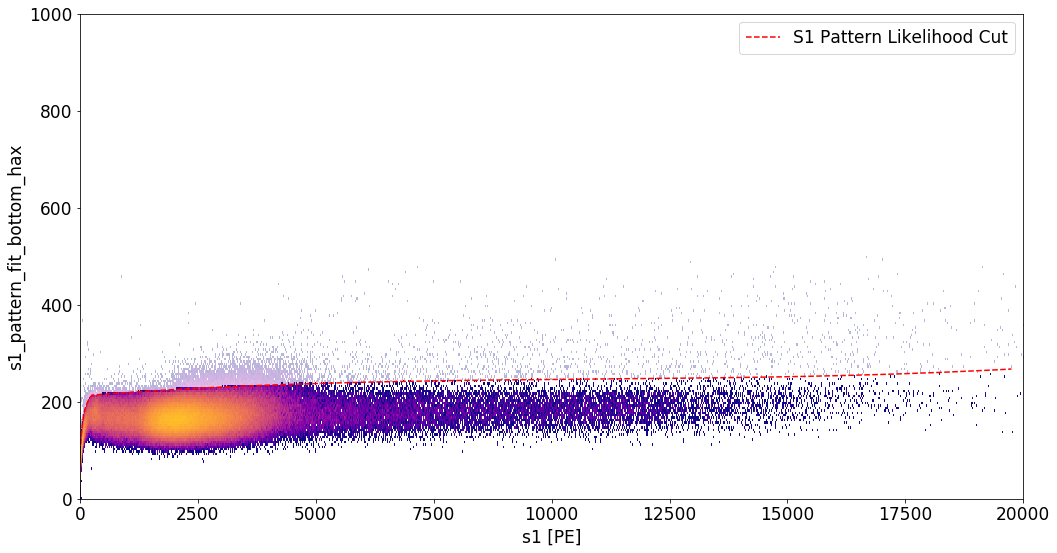

In [47]:
y_valid = []
for i in range(len(xbins_center_valid)):
    y_valid.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid[i], *popt_1))*(xbins_center_valid[i]<xbins_center_valid[idx][0]) + \
                 (poly3(xbins_center_valid[i], *popt_2))*(xbins_center_valid[i]>=xbins_center_valid[idx][0]))

plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [48]:
len(data_cut)/len(data), hist_cut.sum()/hist.sum()

(0.9821877096005736, 0.98218770960057356)

In [49]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_ = (xbins_cut[i+1] + xbins_cut[i])/2.
    acc = hist_cut[i].sum()/hist[i].sum()
    sig = np.sqrt(acc*(1-acc)/hist[i].sum())
    if np.isnan(acc)==False and acc!=0:
        bin_centers_acceptance.append(bin_)
        acceptance.append(acc)
        sigma.append(sig)
        print(bin_, acc, sig)
            
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
#acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
#sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(sigma)

print(acceptance_mean)

5.0 1.0 0.0
15.0 0.9956837801 0.000988069465639
25.0 0.996971532405 0.000956234282725
35.0 0.996619083396 0.00112506548886
45.0 0.995446265938 0.00143673468073
55.0 0.99067357513 0.00218798445941
65.0 0.986494782075 0.00285981310738
75.0 0.985396383866 0.00316341553777
85.0 0.983918128655 0.00340098506102
95.0 0.96962430056 0.00485217252338
105.0 0.969439728353 0.00501494722035
115.0 0.960820895522 0.00592585580522
125.0 0.970249520154 0.00526326026649
135.0 0.953813104189 0.00687885554159
145.0 0.958139534884 0.00682915829337
155.0 0.948035487959 0.00790182163857
165.0 0.961165048544 0.00673049122561
175.0 0.963157894737 0.00683304322112
185.0 0.956 0.00748901417633
195.0 0.965467625899 0.00692611461457
205.0 0.965267727931 0.00696548669102
215.0 0.95251396648 0.00794807785169
225.0 0.973474801061 0.00585202279298
235.0 0.979020979021 0.00535963959463
245.0 0.973684210526 0.00580644704051
255.0 0.979328165375 0.00511426412277
265.0 0.980810234542 0.00447946253535
275.0 0.969696969697 

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


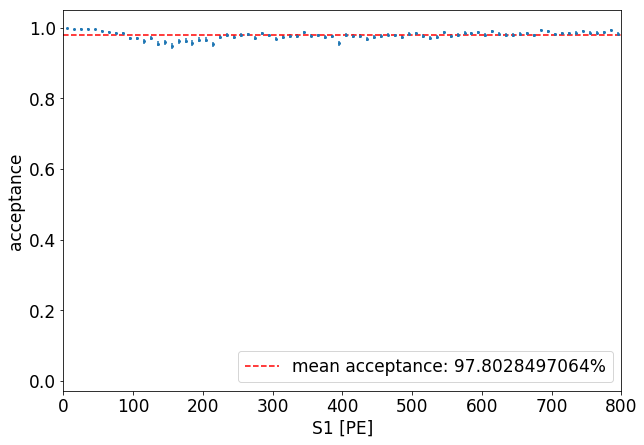

In [57]:
acceptance_mean = np.mean(acceptance[:80])
acceptance_median = np.median(acceptance[:80])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=8e2, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 800)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

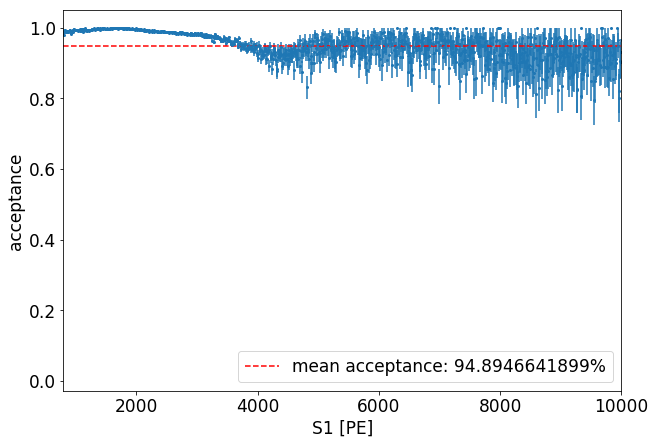

In [59]:
acceptance_mean = np.mean(acceptance[80:1000])
acceptance_median = np.median(acceptance[80:1000])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=8e2, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(8e2, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

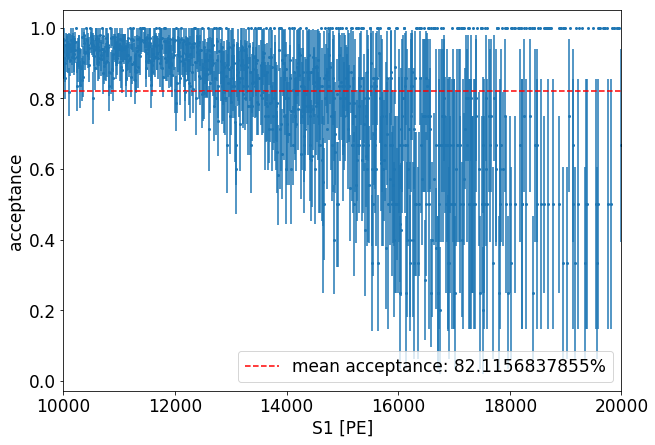

In [62]:
acceptance_mean = np.mean(acceptance[1000:])
acceptance_median = np.median(acceptance[1000:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

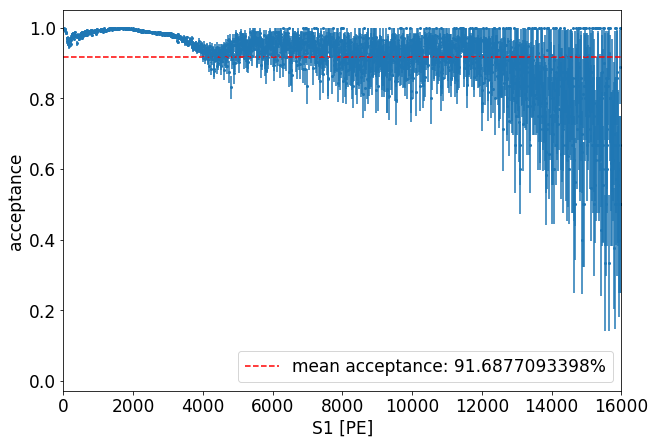

In [64]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance[:1600])
acceptance_median = np.median(acceptance[:1600])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 1.6e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [90]:
from statsmodels.stats.proportion import proportion_confint
binomial_error_method = 'beta'
binomial_alpha = 0.68


def acceptance(data_before, data_after):
    after, bins=np.histogram(data_after ,bins=Bins, range=hist_range)
    before, bins=np.histogram(data_before ,bins=Bins, range=hist_range)

    acceptance = after/before
    error = proportion_confint(after, before, method=binomial_error_method, alpha=binomial_alpha)
    err_low = error[0]
    err_high = error[1]
    yerr_low, yerr_high = (acceptance - err_low, err_high - acceptance)
    err = (yerr_low, yerr_high)

    plt.errorbar(binn, acceptance, err,0, marker='.', markersize=5, linestyle="", linewidth=0.5, color='navy')
    plt.axhline(y=1, color='k',linestyle='--')
    plt.ylabel('acceptance')
    plt.ylim(0,1.05)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


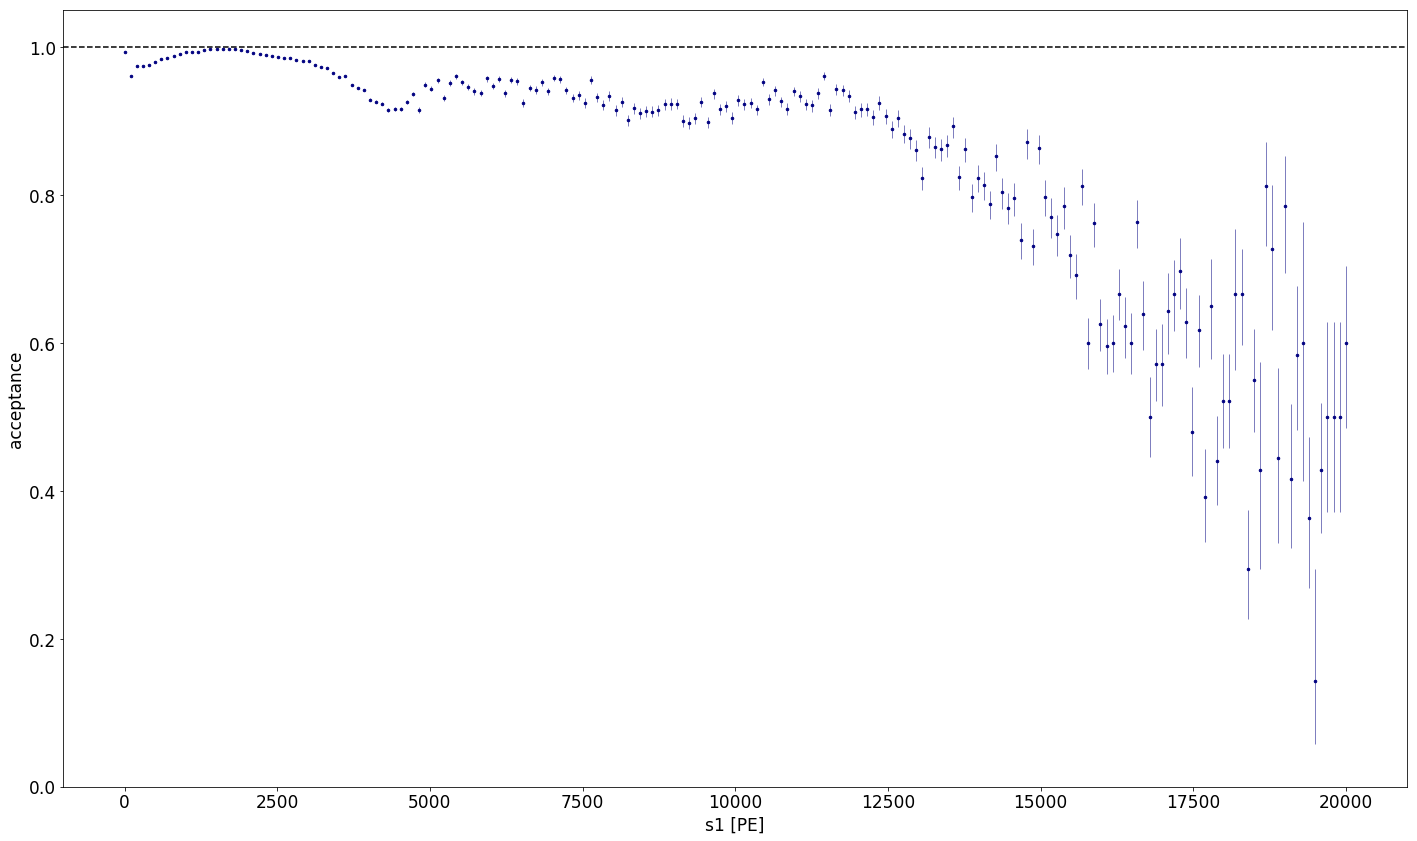

In [95]:
Bins=200
hist_range=([0,2e4])  
binn=np.linspace(0,2e4,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(data.s1,data_cut.s1)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s1 [PE]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Acceptance study on xyz

In [94]:
data_cut_2 = data_cut.copy()
data_cut_2['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(data_cut_2['y_3d_nn_tf']/data_cut_2['x_3d_nn_tf'])
tmp = data_cut_2.copy()
z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2 = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
tmp = data.copy()
z1_white = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2_white = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3_white = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
del tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


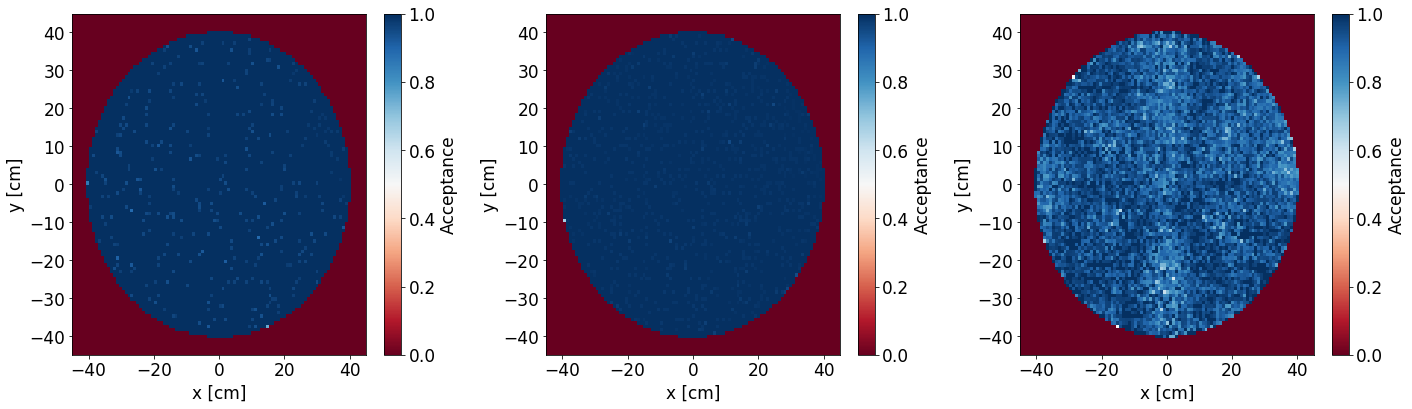

In [96]:
plt.figure(figsize=(20,6))

plt.subplot(131)
hist_data_1, x_data_1, y_data_1 = np.histogram2d(z1_white['x_3d_nn_tf'], z1_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_1, x_cut_1, y_cut_1 = np.histogram2d(z1['x_3d_nn_tf'], z1['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_1 = hist_cut_1/hist_data_1
c_1 = plt.pcolor(x_data_1, y_data_1, Acceptance_xy_1, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(132)
hist_data_2, x_data_2, y_data_2 = np.histogram2d(z2_white['x_3d_nn_tf'], z2_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_2, x_cut_2, y_cut_2 = np.histogram2d(z2['x_3d_nn_tf'], z2['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_2 = hist_cut_2/hist_data_2
c_2 = plt.pcolor(x_data_2, y_data_2, Acceptance_xy_2, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_2, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(133)
hist_data_3, x_data_3, y_data_3 = np.histogram2d(z3_white['x_3d_nn_tf'], z3_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_3, x_cut_3, y_cut_3 = np.histogram2d(z3['x_3d_nn_tf'], z3['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_3 = hist_cut_3/hist_data_3
c_3 = plt.pcolor(x_data_3, y_data_3, Acceptance_xy_3, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_3, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.tight_layout()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:68: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


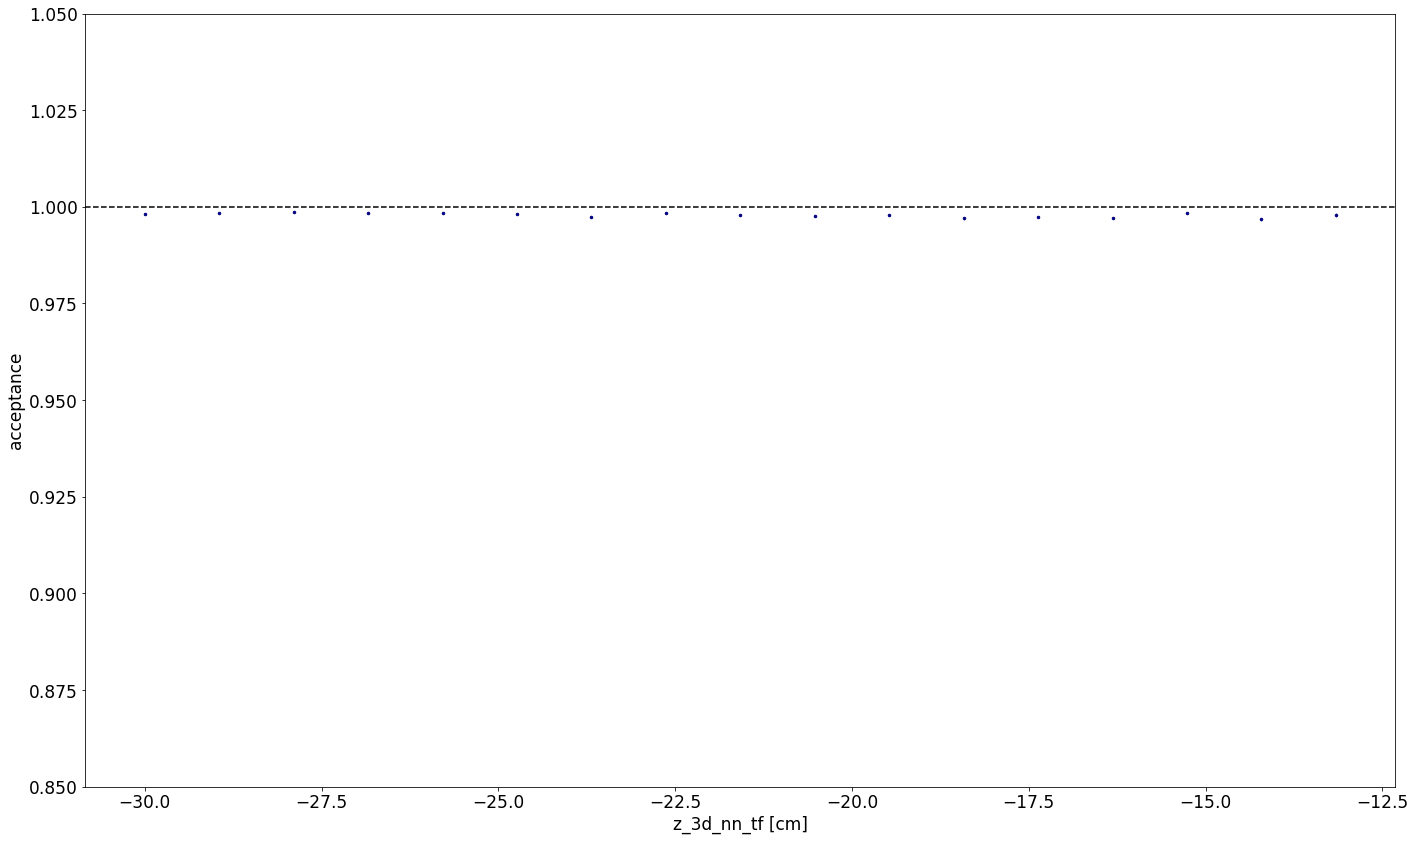

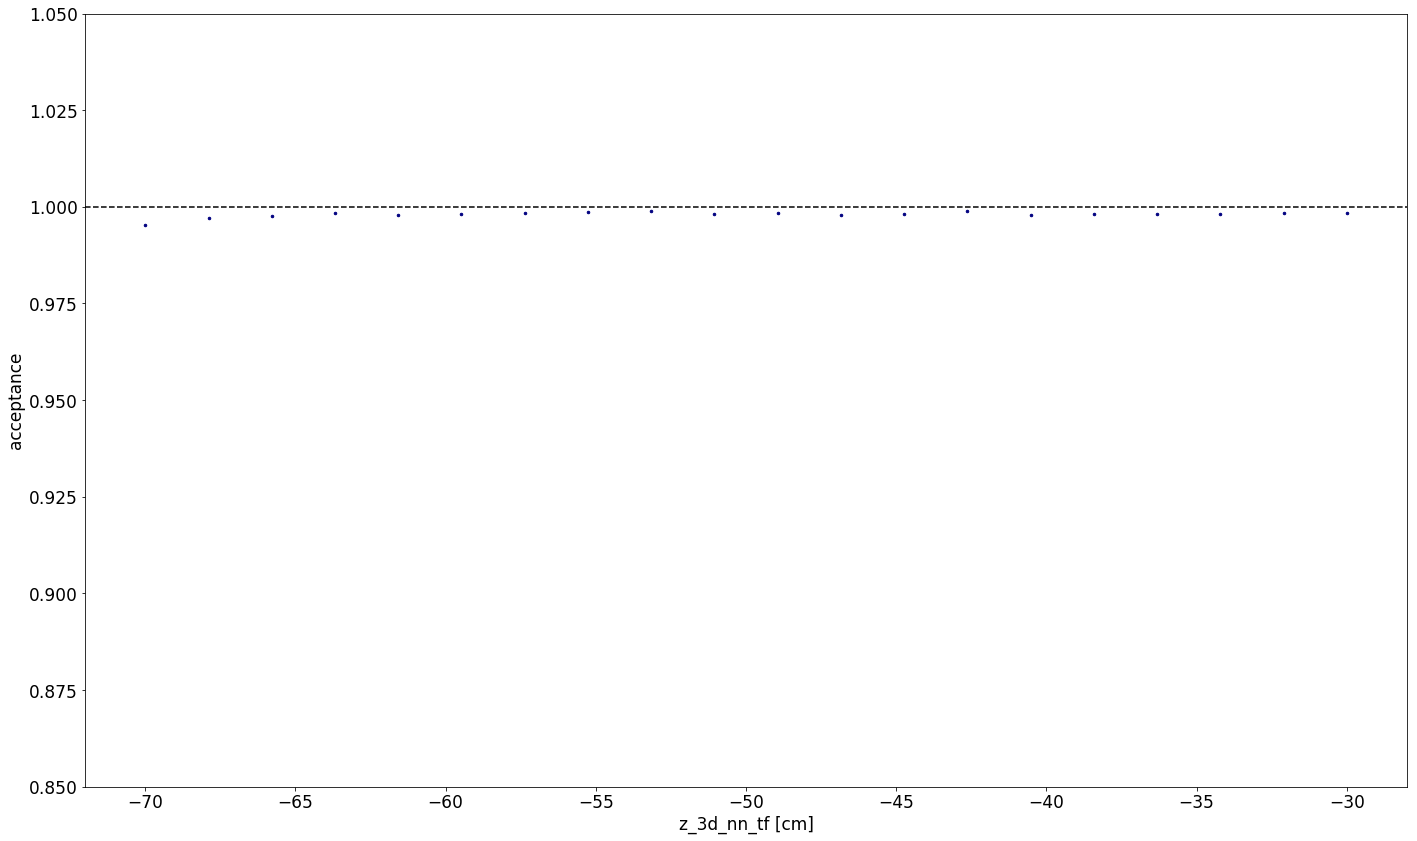

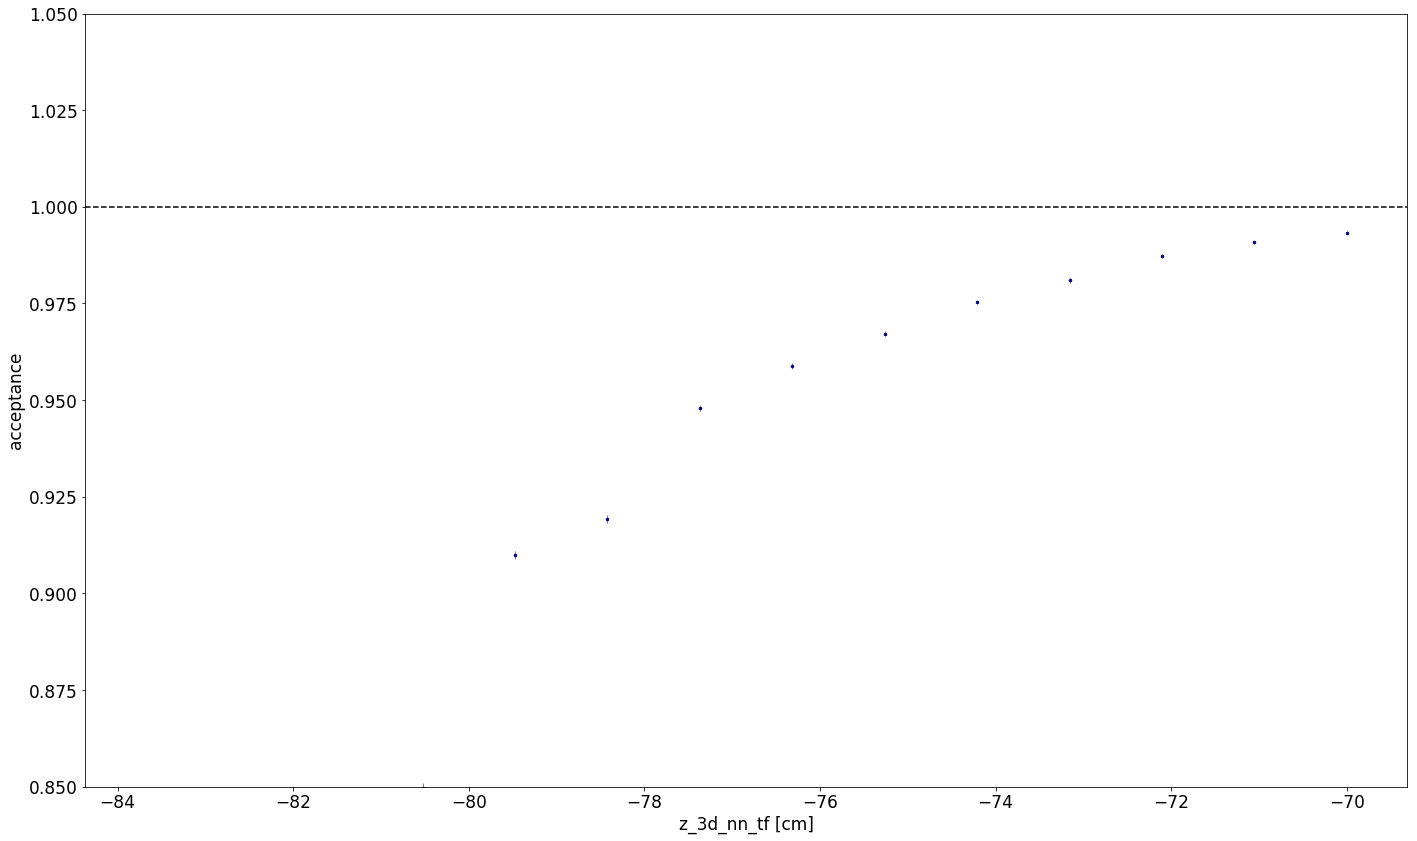

In [108]:
Bins=20
hist_range=([-30, -10])  
binn=np.linspace(-30,-10,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z1_white.z_3d_nn_tf, z1.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

Bins=20
hist_range=([-70, -30])  
binn=np.linspace(-70,-30,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z2_white.z_3d_nn_tf, z2.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

Bins=20
hist_range=([-90, -70])  
binn=np.linspace(-90,-70,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z3_white.z_3d_nn_tf, z3.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()